# Cassiopeia Benchmarking Pipeline

This notebook serves as an entry point for understanding how to interface with Cassiopeia for the purposes of simulating trees, data, benchmarking algorithms.

You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/testdeployment/installation).

All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/testdeployment/).

In [1]:
import cProfile
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from tqdm.auto import tqdm

import cassiopeia as cas
from cassiopeia.solver import missing_data_methods

In [2]:
from IPython.display import Image


## Tree Simulation

We can use a simple birth-death model with fitness to simulate trees.

Specifically, this is a continuous-time birth-death process in which birth and death events are sampled from indepedent waiting distributions. Importnatly, we can incorporate fitness into this framework by modulating the `scale` of the birth waiting distribution. This is done by sampling a random number of fitness events per generation, each with a fitness effect drawn from a distribution. The documentation for this class can be found [here](https://cassiopeia-lineage.readthedocs.io/en/testdeployment/api/reference/cassiopeia.sim.BirthDeathFitnessSimulator.html). 

In [10]:
bd_sim = cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution = lambda scale: np.random.exponential(scale),
    initial_birth_scale = 0.5,
    death_waiting_distribution = lambda: np.random.exponential(1.5),
    mutation_distribution = lambda: 1 if np.random.uniform() < 0.5 else 0,
    fitness_distribution = lambda: np.random.normal(0, .5),
    fitness_base = 1.3,
    num_extant = 400,
    random_seed=17
)
ground_truth_tree = bd_sim.simulate_tree()

We can upload and export trees to iTOL which we can visualize in line. You can toggle branch lengths with the `use_branch_lengths` parameter. 

In [ ]:
cas.pl.upload_and_export_itol(ground_truth_tree,
                              itol_config="~/.itolconfig_hidden",
                              tree_name = "simulated_tree",
                              export_filepath="simulated_tree_example.png",
                             use_branch_lengths=True)

In [ ]:
Image("simulated_tree_example.png", width=500, height=500)

## Overlay Lineage Tracing Data

We can then use our Cas9-based lineage tracing data simulator to overlay data. Here, this is a very flexible Cas9-data generator in which we can specify the dependence structure between characters (i.e. the cassettes that link togehter cut sites), the mutation rate, silencing rates, and state distributions. This function derives from the DataSimulator class & implements the `overlay_data` function which operates on a `CassiopeiaTree`, such as the one you simulated above. 

In [11]:
np.random.seed(seed=None)
lt_sim = cas.sim.Cas9LineageTracingDataSimulator(
    number_of_cassettes = 40,
    size_of_cassette = 1,
    mutation_rate = 0.1,
    state_generating_distribution = lambda: np.random.exponential(1e-5),
    number_of_states = 50,
    state_priors = None,
    heritable_silencing_rate = 9e-4,
    stochastic_silencing_rate = 0.1,
    heritable_missing_data_state = -1,
    stochastic_missing_data_state = -1,
)
lt_sim.overlay_data(ground_truth_tree)

We can get a feel for the character matrix and the complexity of the data here by extracting the simulated data.

We simulated 40 characters across 400 cells.


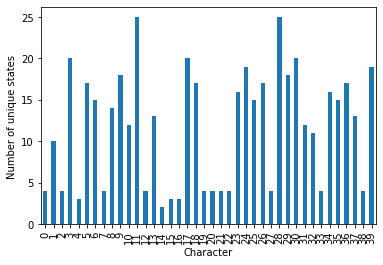

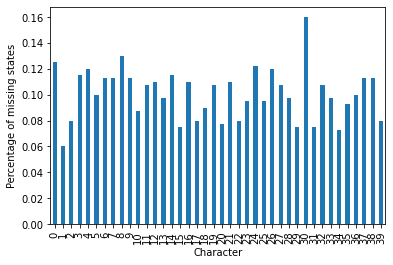

In [12]:
## inspect character matrix

character_matrix = ground_truth_tree.character_matrix

print(f"We simulated {character_matrix.shape[1]} characters across {character_matrix.shape[0]} cells.")

# plot the number of unique states per character
character_matrix.nunique(axis=0).plot(kind='bar')
plt.xlabel("Character")
plt.ylabel("Number of unique states ")
plt.show()

missing_data_per_character = character_matrix.apply(lambda x: len(x[x == -1]) / len(x), axis=0)
missing_data_per_character.plot(kind='bar')
plt.xlabel("Character")
plt.ylabel("Percentage of missing states")
plt.show()

## Rebuild trees

Cassiopeia has implemented several CassiopeiaSolvers for reconstructing trees. Each of these can take in several class-specific parameters and at a minimum implements the `solve` routine which operates on a CassiopeiaTree. 

The full list of solvers can be found [here](https://cassiopeia-lineage.readthedocs.io/en/testdeployment/api/solver.html). For a full tutorial on tree reconstruction, refer to the [Tree Reconstruction notebook](https://github.com/YosefLab/Cassiopeia/blob/testdeployment/notebooks/reconstruct.ipynb).

Here we use the VanillaGreedySolver, which was described in the [Cassiopeia paper published in 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02000-8).

In [13]:
reconstructed_tree = cas.data.CassiopeiaTree(character_matrix = ground_truth_tree.character_matrix, missing_state_indicator = -1)

greedy_solver = cas.solver.VanillaGreedySolver()
greedy_solver.solve(reconstructed_tree)


In [ ]:
# plot tree

cas.pl.upload_and_export_itol(reconstructed_tree, itol_config="~/.itolconfig_hidden", tree_name = "reconstructed_simulated_tree", export_filepath="reconstructed_simulated_tree.png")

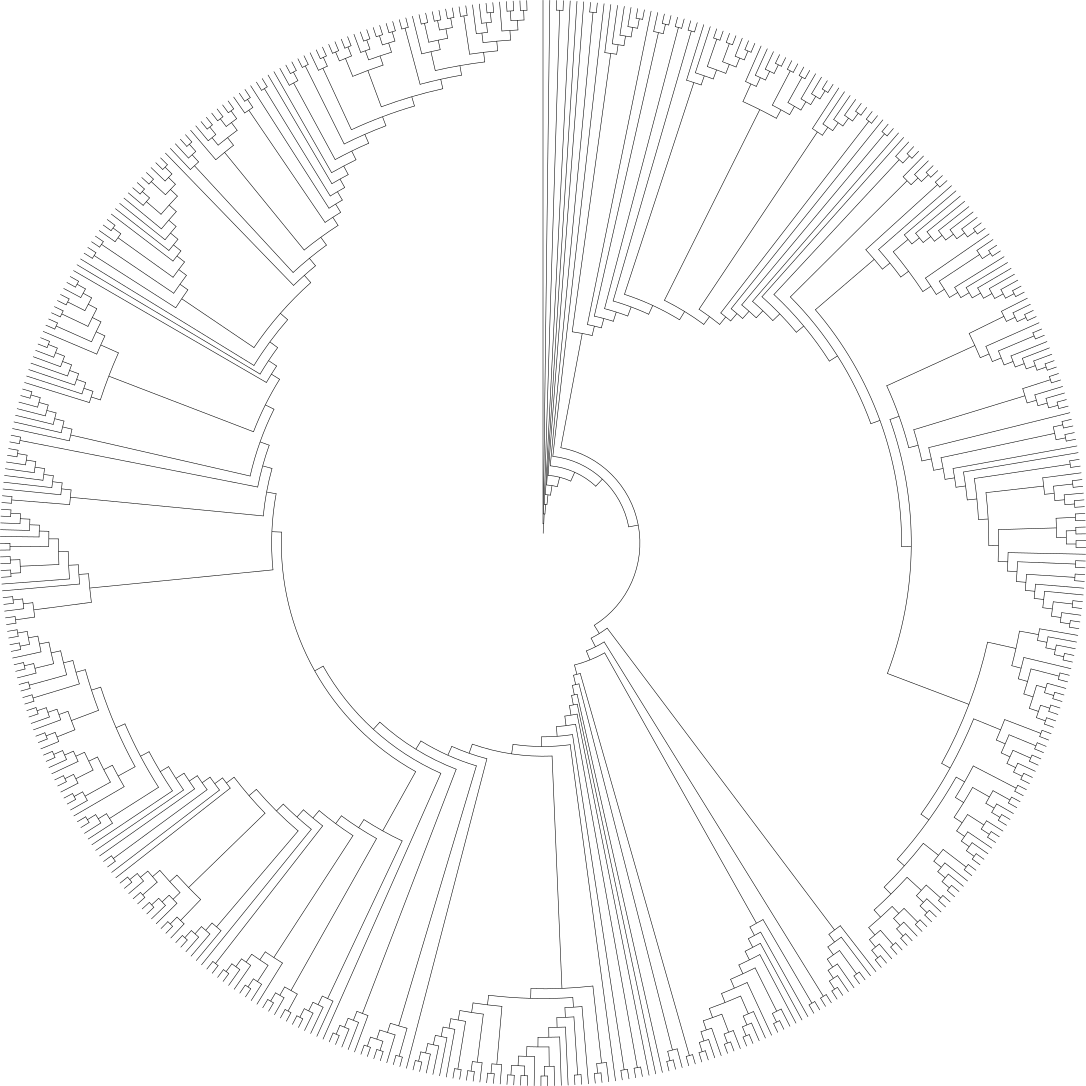

In [26]:
Image("reconstructed_simulated_tree.png", width=500, height=500)

## Critique

Our `critique` library is for testing the similarity between CassiopeiaTrees. The most pertinent use case is when comparing the reconstruction accuracy. We have two metrics implemented - a triplets correct measure, and the Robinson-Foulds metric.

In [14]:
reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters = True)

rf, rf_max = cas.critique.compare.robinson_foulds(ground_truth_tree, reconstructed_tree)

print(f"Normalized RF: {rf / rf_max}")

Normalized RF: 0.6981132075471698


In [15]:
triplets = cas.critique.compare.triplets_correct(ground_truth_tree, reconstructed_tree, number_of_trials = 500)

## Building benchmarking pipelines

We can link all of these steps together to benchmark the performance of several algorithms.

The briefest of benchmarking pipelines would consist of:

- Simulating a ground truth phylogeny
- Overlaying data onto this phylogeny
- Inferring the phylogeny with potentially many algorithms
- Assessing performance

Here we show a very simple benchmarking pipeline:

In [17]:

algorithms = {"Vanilla Greedy": cas.solver.VanillaGreedySolver(),
              'UPGMA': cas.solver.UPGMASolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance),
              'NeighborJoining': cas.solver.NeighborJoiningSolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance, add_root=True)
             }

iterations = 10

algorithm_to_performance_triplets = defaultdict(list)
algorithm_to_performance_rf = defaultdict(list)
for _ in tqdm(range(iterations)):
    
    ground_truth_tree = bd_sim.simulate_tree()
    
    np.random.seed(None)
    lt_sim.overlay_data(ground_truth_tree)
    
    for algorithm_name in tqdm(algorithms.keys()):
        
        algorithm = algorithms[algorithm_name]
        
        reconstructed_tree = cas.data.CassiopeiaTree(character_matrix = ground_truth_tree.character_matrix, missing_state_indicator = -1)
        algorithm.solve(reconstructed_tree)
        
        # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
        reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters = True)

        rf, rf_max = cas.critique.compare.robinson_foulds(ground_truth_tree, reconstructed_tree)
        
        triplets = cas.critique.compare.triplets_correct(ground_truth_tree, reconstructed_tree, number_of_trials=500)
        algorithm_to_performance_triplets[algorithm_name].append(np.mean(list(triplets[0].values())))
        
        algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

        
        
        

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

We can easily visualize results after reformatting the dictionaries of performances

In [18]:
algorithm_to_performance_triplets_df = pd.DataFrame(columns = ['Algorithm', 'Triplets'])
for algorithm in algorithm_to_performance_triplets:
    
    entries = algorithm_to_performance_triplets[algorithm]
    new_df = pd.DataFrame([algorithm]*len(entries), columns = ['Algorithm'])
    new_df['Triplets'] = entries
    
    algorithm_to_performance_triplets_df = pd.concat([algorithm_to_performance_triplets_df, new_df])
    
algorithm_to_performance_rf_df = pd.DataFrame(columns = ['Algorithm', 'RF'])
for algorithm in algorithm_to_performance_rf:
    
    entries = algorithm_to_performance_rf[algorithm]
    new_df = pd.DataFrame([algorithm]*len(entries), columns = ['Algorithm'])
    new_df['RF'] = entries
    
    algorithm_to_performance_rf_df = pd.concat([algorithm_to_performance_rf_df, new_df])

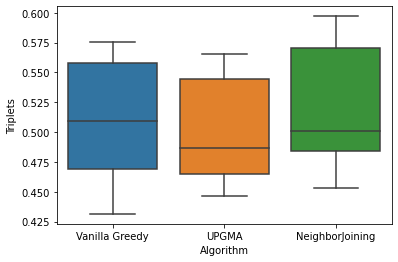

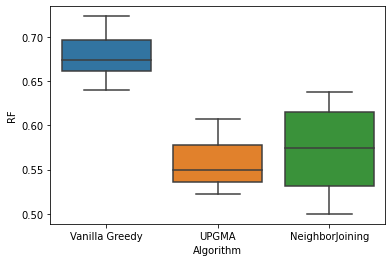

In [19]:
sns.boxplot(data=algorithm_to_performance_triplets_df, x = 'Algorithm', y = 'Triplets')
plt.show()

sns.boxplot(data=algorithm_to_performance_rf_df, x = 'Algorithm', y = 'RF')
plt.show()